# Day 5-6: Advanced Techniques

**Goal:** Expand probe toolkit with position analysis, attention head probing, and component-specific extraction

**Learning Objectives:**
1. Compare different token positions for probe accuracy
2. Extract and probe attention head outputs
3. Extract and probe MLP layer outputs
4. Build a reusable ProbeToolkit class

**Timeline:** 6-8 hours

**Why This Matters for Faithfulness Detection:**
- H2 predicts information is concentrated at conclusion tokens ("therefore", "so")
- We need to systematically compare positions to test this
- Different model components may encode different aspects of faithfulness

---

## Setup

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import transformer_lens as tl

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

c:\Users\ndcm1133\OneDrive - Nexus365\Desktop\AI_Safety_Projects\AI-safety-research\mech_interp_env_py311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PyTorch version: 2.9.1+cpu
CUDA available: False


In [2]:
# Load GPT-2 small
model = tl.HookedTransformer.from_pretrained("gpt2-small")
print(f"Model loaded: {model.cfg.n_layers} layers, {model.cfg.d_model} dimensions")
print(f"Attention heads per layer: {model.cfg.n_heads}")
print(f"Head dimension: {model.cfg.d_head}")

`torch_dtype` is deprecated! Use `dtype` instead!


Loaded pretrained model gpt2-small into HookedTransformer
Model loaded: 12 layers, 768 dimensions
Attention heads per layer: 12
Head dimension: 64


In [17]:
model.cfg

HookedTransformerConfig:
{'NTK_by_parts_factor': 8.0,
 'NTK_by_parts_high_freq_factor': 4.0,
 'NTK_by_parts_low_freq_factor': 1.0,
 'NTK_original_ctx_len': 8192,
 'act_fn': 'gelu_new',
 'attention_dir': 'causal',
 'attn_only': False,
 'attn_scale': 8.0,
 'attn_scores_soft_cap': -1.0,
 'attn_types': None,
 'checkpoint_index': None,
 'checkpoint_label_type': None,
 'checkpoint_value': None,
 'd_head': 64,
 'd_mlp': 3072,
 'd_model': 768,
 'd_vocab': 50257,
 'd_vocab_out': 50257,
 'decoder_start_token_id': None,
 'default_prepend_bos': True,
 'device': device(type='cpu'),
 'dtype': torch.float32,
 'eps': 1e-05,
 'experts_per_token': None,
 'final_rms': False,
 'from_checkpoint': False,
 'gated_mlp': False,
 'init_mode': 'gpt2',
 'init_weights': False,
 'initializer_range': 0.02886751345948129,
 'load_in_4bit': False,
 'model_name': 'gpt2',
 'n_ctx': 1024,
 'n_devices': 1,
 'n_heads': 12,
 'n_key_value_heads': None,
 'n_layers': 12,
 'n_params': 84934656,
 'normalization_type': 'LNPre',
 '

In [3]:
# Reuse dataset from Day 3-4
positive_sentences = [
    "I love this movie!",
    "This is amazing and wonderful!",
    "Great job, fantastic work!",
    "I absolutely loved every minute of that film.",
    "This is the best coffee I've ever tasted.",
    "She was so kind and helpful throughout the process.",
    "What a beautiful day to be outside.",
    "I'm thrilled with how the project turned out.",
    "The team did an outstanding job on this.",
    "I can't wait to visit again next year.",
    "This restaurant exceeded all my expectations.",
    "He's such a talented and generous person.",
    "I feel incredibly grateful for this opportunity.",
    "The service here is always fantastic.",
    "That was the most fun I've had in ages.",
    "I'm so proud of what we accomplished together.",
    "This book changed my perspective completely.",
    "The sunset tonight was absolutely stunning.",
    "I've never felt more welcomed anywhere.",
    "Everything about this experience was delightful.",
    "She gave the most inspiring speech I've ever heard.",
    "I'm genuinely excited about what's next.",
    "This made my whole week better.",
]

negative_sentences = [
    "I hate this movie.",
    "This is terrible and awful.",
    "Poor job, disappointing work.",
    "I was deeply disappointed by the outcome.",
    "The food was cold and tasteless.",
    "This has been the worst customer service experience.",
    "I regret wasting my time on this.",
    "The whole event was a complete disaster.",
    "I'm frustrated with how poorly this was handled.",
    "Nothing about this met my expectations.",
    "The quality has really gone downhill.",
    "I felt completely ignored the entire time.",
    "This product broke after just one use.",
    "What a miserable waste of money.",
    "I've never been so let down by a company.",
    "The atmosphere was unpleasant and unwelcoming.",
    "I'm annoyed that nobody bothered to help.",
    "This ruined what should have been a good day.",
    "The wait was unbearable and unnecessary.",
    "I found the whole thing incredibly tedious.",
    "They clearly don't care about their customers.",
    "I'm upset that this turned out so badly.",
    "Everything that could go wrong did."
]

print(f"Dataset: {len(positive_sentences)} positive, {len(negative_sentences)} negative")

Dataset: 23 positive, 23 negative


---

## Part 1: Token Position Analysis (2-3 hours)

**Question:** Which token position contains the most sentiment information?

**Options to explore:**
- **Last token:** Common choice, contains accumulated information
- **First token:** Beginning of sentence
- **Mean pooling:** Average across all tokens
- **Max pooling:** Maximum activation across positions
- **Specific positions:** e.g., position 0, 1, 2, etc.

**For CoT faithfulness:** This maps directly to H2 - whether information is concentrated at conclusion markers

### 1.1 Get ALL Token Activations

In [ ]:
def get_all_token_activations(model, sentences, layer=6):
    """
    Get activations for ALL tokens in each sentence.
    
    Args:
        model: HookedTransformer model
        sentences: List of strings
        layer: Which layer to extract from
    
    Returns:
        List of numpy arrays, each of shape (seq_len, d_model)
        (Note: different sentences may have different seq_len)
    """
    all_activations = []
    
    for sentence in sentences:
        _, cache = model.run_with_cache(sentence)
        # Shape: [1, seq_len, d_model]
        acts = cache["resid_post", layer][0, :, :].cpu().numpy()
        all_activations.append(acts)
    
    return all_activations

# Test it
test_acts = get_all_token_activations(model, ["Hello world!"], layer=6)
print(f"Single sentence activations shape: {test_acts[0].shape}")

# Show token breakdown
tokens = model.to_tokens("Hello world!")
print(f"Tokens: {[model.tokenizer.decode([t]) for t in tokens[0]]}")

Single sentence activations shape: (5, 768)
Tokens: ['<|endoftext|>', 'I', ' see', ' you', '!']


### 1.2 Extract Features by Position Method

In [8]:
def extract_features(activations, method='last'):
    """
    Extract single feature vector from variable-length activations.
    
    Args:
        activations: List of numpy arrays, each (seq_len, d_model)
        method: 'last', 'first', 'mean', 'max'
    
    Returns:
        numpy array of shape (n_samples, d_model)
    """
    features = []
    
    for acts in activations:
        if method == 'last':
            features.append(acts[-1])
        elif method == 'first':
            features.append(acts[0])
        elif method == 'mean':
            features.append(acts.mean(axis=0))
        elif method == 'max':
            features.append(acts.max(axis=0))
        else:
            raise ValueError(f"Unknown method: {method}")
    
    return np.array(features)

# Demo
test_acts = get_all_token_activations(model, ["Test sentence here"], layer=6)
for method in ['last', 'first', 'mean', 'max']:
    feat = extract_features(test_acts, method)
    print(f"{method}: shape {feat.shape}, mean={feat.mean():.4f}")

last: shape (1, 768), mean=0.0000
first: shape (1, 768), mean=-0.0000
mean: shape (1, 768), mean=-0.0000
max: shape (1, 768), mean=6.8530


### 1.3 Compare Position Methods

In [9]:
def train_and_evaluate_probe(X_pos, X_neg, test_size=0.3, random_state=42):
    """
    Helper function to train probe and return results.
    """
    X = np.vstack([X_pos, X_neg])
    y = np.array([1]*len(X_pos) + [0]*len(X_neg))
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    probe = LogisticRegression(max_iter=1000, random_state=random_state)
    probe.fit(X_train, y_train)
    
    return {
        'probe': probe,
        'train_acc': probe.score(X_train, y_train),
        'test_acc': probe.score(X_test, y_test),
    }

In [10]:
# Get all activations once (for efficiency)
print("Extracting all token activations...")
pos_all_acts = get_all_token_activations(model, positive_sentences, layer=6)
neg_all_acts = get_all_token_activations(model, negative_sentences, layer=6)
print("Done!")

Extracting all token activations...
Done!


In [11]:
# Compare different position methods
methods = ['last', 'first', 'mean', 'max']
position_results = []

print("\n=== Position Method Comparison ===\n")

for method in methods:
    X_pos = extract_features(pos_all_acts, method)
    X_neg = extract_features(neg_all_acts, method)
    
    results = train_and_evaluate_probe(X_pos, X_neg)
    
    position_results.append({
        'method': method,
        'train_acc': results['train_acc'],
        'test_acc': results['test_acc'],
        'gap': results['train_acc'] - results['test_acc']
    })
    
    print(f"{method:6s}: Train={results['train_acc']:.2%}, Test={results['test_acc']:.2%}")

df_position = pd.DataFrame(position_results)
print(f"\nBest method: {df_position.loc[df_position['test_acc'].idxmax(), 'method']}")


=== Position Method Comparison ===

last  : Train=100.00%, Test=85.71%
first : Train=50.00%, Test=50.00%
mean  : Train=100.00%, Test=85.71%
max   : Train=100.00%, Test=92.86%

Best method: max


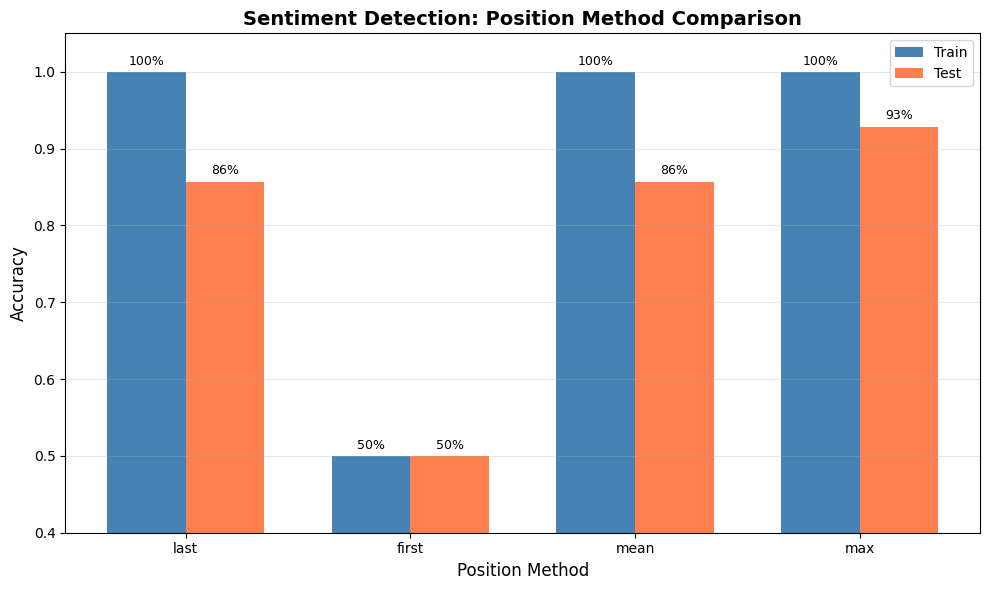

In [12]:
# Visualize position comparison
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(methods))
width = 0.35

bars1 = ax.bar(x - width/2, df_position['train_acc'], width, label='Train', color='steelblue')
bars2 = ax.bar(x + width/2, df_position['test_acc'], width, label='Test', color='coral')

ax.set_xlabel('Position Method', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Sentiment Detection: Position Method Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(methods)
ax.legend()
ax.set_ylim([0.4, 1.05])
ax.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.0%}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('position_method_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

### 1.4 Position-by-Position Analysis

**Let's go deeper:** Which specific token positions carry the most information?

In [13]:
def extract_at_position(activations, position):
    """
    Extract activation at specific position.
    
    Args:
        activations: List of numpy arrays
        position: int (positive) or negative (from end)
    
    Returns:
        numpy array of shape (n_valid_samples, d_model)
        List of valid indices (samples that had enough tokens)
    """
    features = []
    valid_indices = []
    
    for i, acts in enumerate(activations):
        seq_len = acts.shape[0]
        
        # Handle negative indices (from end)
        if position < 0:
            actual_pos = seq_len + position
        else:
            actual_pos = position
        
        # Check if position is valid for this sequence
        if 0 <= actual_pos < seq_len:
            features.append(acts[actual_pos])
            valid_indices.append(i)
    
    return np.array(features), valid_indices

# Test
test_feat, test_idx = extract_at_position(pos_all_acts, position=0)
print(f"Position 0: {len(test_feat)} valid samples")
test_feat, test_idx = extract_at_position(pos_all_acts, position=-1)
print(f"Position -1 (last): {len(test_feat)} valid samples")

Position 0: 23 valid samples
Position -1 (last): 23 valid samples


In [14]:
# Analyze multiple positions
positions_to_test = [0, 1, 2, 3, -3, -2, -1]  # First few and last few
position_specific_results = []

print("\n=== Position-Specific Analysis ===\n")

for pos in positions_to_test:
    X_pos_feat, pos_idx = extract_at_position(pos_all_acts, pos)
    X_neg_feat, neg_idx = extract_at_position(neg_all_acts, pos)
    
    # Only proceed if we have enough samples
    if len(X_pos_feat) >= 5 and len(X_neg_feat) >= 5:
        # Need balanced dataset - take minimum
        min_samples = min(len(X_pos_feat), len(X_neg_feat))
        X_pos_feat = X_pos_feat[:min_samples]
        X_neg_feat = X_neg_feat[:min_samples]
        
        results = train_and_evaluate_probe(X_pos_feat, X_neg_feat)
        
        position_specific_results.append({
            'position': pos,
            'n_samples': min_samples * 2,
            'train_acc': results['train_acc'],
            'test_acc': results['test_acc'],
        })
        
        pos_label = f"{pos}" if pos >= 0 else f"last{pos+1}" if pos != -1 else "last"
        print(f"Position {pos:3d}: n={min_samples*2:2d}, Train={results['train_acc']:.2%}, Test={results['test_acc']:.2%}")
    else:
        print(f"Position {pos:3d}: Insufficient samples (pos={len(X_pos_feat)}, neg={len(X_neg_feat)})")


=== Position-Specific Analysis ===

Position   0: n=46, Train=50.00%, Test=50.00%
Position   1: n=46, Train=62.50%, Test=57.14%
Position   2: n=46, Train=90.62%, Test=42.86%
Position   3: n=46, Train=100.00%, Test=57.14%
Position  -3: n=46, Train=100.00%, Test=64.29%
Position  -2: n=46, Train=100.00%, Test=92.86%
Position  -1: n=46, Train=100.00%, Test=85.71%


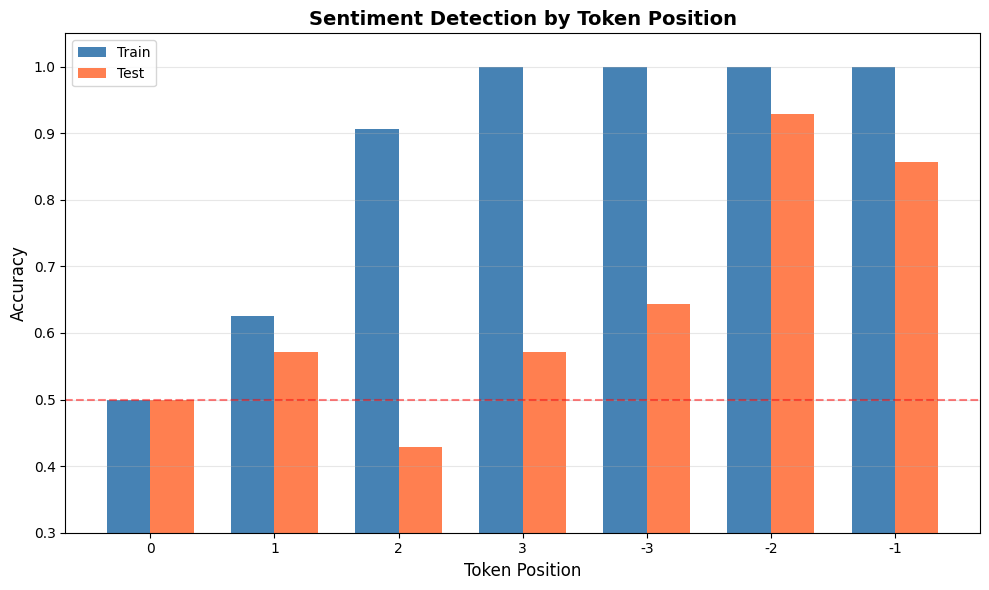

In [15]:
# Visualize position-specific results
if position_specific_results:
    df_pos_specific = pd.DataFrame(position_specific_results)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    positions = [str(p) for p in df_pos_specific['position']]
    x = np.arange(len(positions))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, df_pos_specific['train_acc'], width, label='Train', color='steelblue')
    bars2 = ax.bar(x + width/2, df_pos_specific['test_acc'], width, label='Test', color='coral')
    
    ax.set_xlabel('Token Position', fontsize=12)
    ax.set_ylabel('Accuracy', fontsize=12)
    ax.set_title('Sentiment Detection by Token Position', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(positions)
    ax.legend()
    ax.set_ylim([0.3, 1.05])
    ax.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Random')
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig('position_specific_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()

### Position Analysis Reflection

**Answer these questions:**

1. **Which position(s) work best?** Is this what you expected?
   - Your answer: The position with the highest accuracy on the test dataset is the second last position with an accuracy of 92.86%, while the last position has the second highest accuracy with a value of 85.71%. I expected the last, not the second last, position to have the highest accuracy as it should have access to the maximum information, i.e. all the tokens in the context. I'm not sure if this is a robust or brittle observation, so would need to run additional tests to investigate whether the second last position consistently performs best. 

   Feedback from Claude: This is a real phenomenon. The second-last token outperforming the last token position is a real phenomenon, not noise. The last token is where the model is preparing its next token prediction. At that position, the residual stream is being transformed toward logit computation - the model is "thinking about what to output next," not representing the sentence's meaning. 

   The second-lasat token isn't burdened with output preparation. It can maintain a cleaner semantic representation of the sentence content. This is relevant for the faithfulness work since the position where a model "knows" something may not by the position where it's "acting on" that knowledge.

2. **Why might the last token contain more sentiment information?**
   - Your answer: I think that the last token contains more sentiment information than earlier tokens because it has access to more representations in the models residual stream than earlier tokens in the context. 

   Feedback from Claude: I'm using the wrong framing and conflating two things here. 1) Causal access to prior tokens (yes, later positions can attend to more tokens) and 2) representation quality are not the same thing.

   The last token has access to all prior tokens via attention, but that doesn't mean its residual stream state is the best place to probe for sentiment. As highlighted in the answer to question 1, the representation for the last token is shaped by the next-token prediction objective.

   A better framing is to think of it that later positions can integrate information from the full context via attention, but the use of the position (output prediction vs. internal representation) affects what's linearly accessible there. 

3. **For CoT faithfulness detection, which positions might be most informative?** (Think about where conclusions appear)
   - Your answer: I'm not sure, but I'd guess that the positions which would be most informative for faithfulness detection would be ones where words like "therefore" or other similar type conclusion words occur. There are probably other examples of things that I am not thinking of though too.

   Feedback from Claude: You only focused on conclusion words like "therefore". That's one hypothesis (and aligns with H2 of the faithfulness probe project), but you're missing other candidates:

   Other positions to consider for faithfulness:
   - Conclusion tokens ("therefore", "so", "thus") - where stated reasoning connects to answer
   - Answer tokens - where the model commits to an output
   - Key reasoning step tokens - where actual computation might happen 
   - End of reasoning chain - summary position before final answer
   - Transition tokens - between reasoning steps

   **The deeper question:** Is faithfulness information localized to specific positions, or distributed across the reasoning chain? Your probe experiments can test this by comparing single-position probes vs. mean-pooled vs. multi-position probes.

   **Concrete prediction to test:** If faithfulness is about whether stated reasoning caused the conclusion, information might be strongest at the junction between reasoning and conclusion - not at the conclusion itself.

   Learning Note: Think about the positions as "serving different computational roles", not as "having more or less information". The model uses different positions for different purposes, and that affects what's recoverable via linear probes. 





---

## Part 2: Attention Head Probing (2-3 hours)

**Question:** Do specific attention heads specialize in sentiment?

**Background:**
- GPT-2 small has 12 layers × 12 heads = 144 attention heads
- Each head produces a d_head=64 dimensional output
- Different heads may specialize in different tasks

**Why this matters:** Understanding which components encode information helps us target probes effectively

**Additional Notes to Remember when using TransformerLens:**

For attention head outputs, the correct hook name is:

  cache["blocks.6.attn.hook_z"]  # Output of attention heads before projection
  
  or
  
  cache["attn_out", 6]  # After the output projection (W_O), per-layer shorthand

  The common attention-related hooks are:

  | Hook                   | What it captures                                              |
  |------------------------|---------------------------------------------------------------|
  | hook_q, hook_k, hook_v | Query, key, value vectors                                     |
  | hook_z                 | Attention head output (before W_O projection)                 |
  | hook_attn_scores       | Raw attention scores (before softmax)                         |
  | hook_pattern           | Attention pattern (after softmax)                             |
  | attn_out               | Final attention layer output (after W_O, summed across heads) |

  Shape of hook_z: [batch, pos, n_heads, d_head]

In [18]:
def get_attention_head_output(model, sentences, layer=6, head=0):
    """
    Extract output from a specific attention head.
    
    Args:
        model: HookedTransformer model
        sentences: List of strings
        layer: Which layer (0-11 for GPT-2 small)
        head: Which head (0-11 for GPT-2 small)
    
    Returns:
        numpy array of shape (n_sentences, d_head)
    """
    activations = []
    
    for sentence in sentences:
        _, cache = model.run_with_cache(sentence)
        
        # Get attention head result
        # Shape: [batch, pos, n_heads, d_head]
        # This is the output of the attention head BEFORE being projected by W_O
        head_output = cache[f"blocks.{layer}.attn.hook_z"]
        
        # Get last token's activation for the specified head
        # Shape: [d_head] = [64]
        head_act = head_output[0, -1, head, :].cpu().numpy()
        activations.append(head_act)
    
    return np.array(activations)

# Test
test_head = get_attention_head_output(model, ["Test sentence"], layer=6, head=0)
print(f"Attention head output shape: {test_head.shape}")  # Should be (1, 64)

Attention head output shape: (1, 64)


In [19]:
# Scan all heads at a single layer
layer_to_scan = 6
head_results = []

print(f"\n=== Scanning All Heads at Layer {layer_to_scan} ===\n")

for head in range(model.cfg.n_heads):  # 12 heads
    X_pos = get_attention_head_output(model, positive_sentences, layer=layer_to_scan, head=head)
    X_neg = get_attention_head_output(model, negative_sentences, layer=layer_to_scan, head=head)
    
    results = train_and_evaluate_probe(X_pos, X_neg)
    
    head_results.append({
        'layer': layer_to_scan,
        'head': head,
        'train_acc': results['train_acc'],
        'test_acc': results['test_acc'],
    })
    
    print(f"Head {head:2d}: Train={results['train_acc']:.2%}, Test={results['test_acc']:.2%}")

df_heads = pd.DataFrame(head_results)
best_head = df_heads.loc[df_heads['test_acc'].idxmax()]
print(f"\nBest head: {best_head['head']:.0f} with test accuracy {best_head['test_acc']:.2%}")


=== Scanning All Heads at Layer 6 ===

Head  0: Train=93.75%, Test=64.29%
Head  1: Train=93.75%, Test=71.43%
Head  2: Train=93.75%, Test=71.43%
Head  3: Train=100.00%, Test=100.00%
Head  4: Train=100.00%, Test=92.86%
Head  5: Train=100.00%, Test=92.86%
Head  6: Train=96.88%, Test=100.00%
Head  7: Train=100.00%, Test=92.86%
Head  8: Train=96.88%, Test=64.29%
Head  9: Train=71.88%, Test=57.14%
Head 10: Train=81.25%, Test=71.43%
Head 11: Train=100.00%, Test=85.71%

Best head: 3 with test accuracy 100.00%


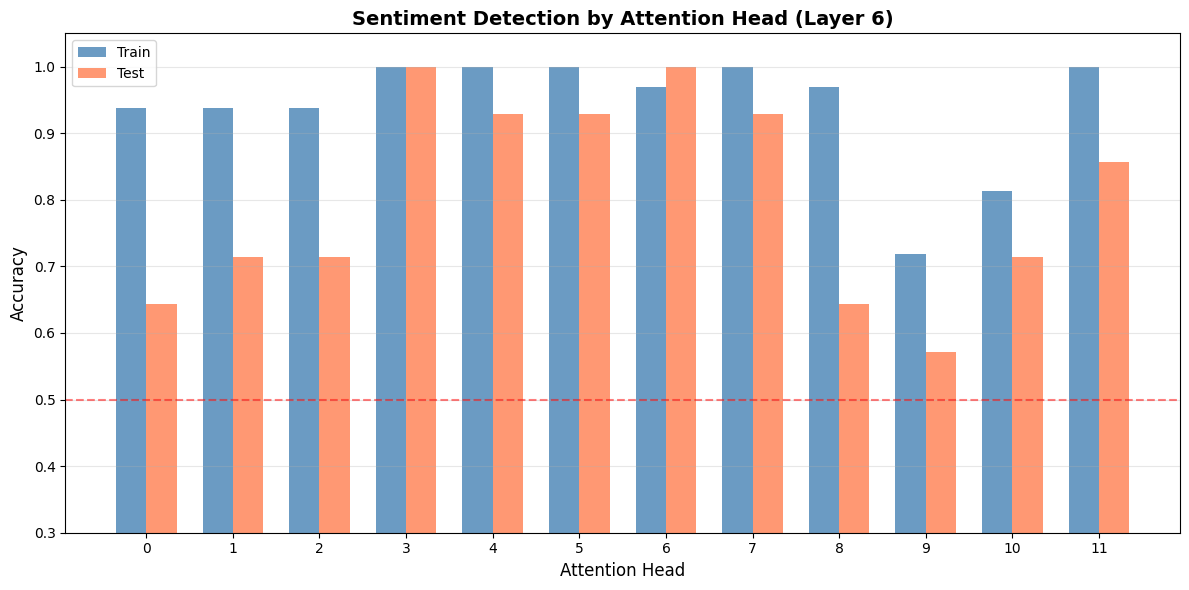

In [20]:
# Visualize head comparison
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(model.cfg.n_heads)
width = 0.35

bars1 = ax.bar(x - width/2, df_heads['train_acc'], width, label='Train', color='steelblue', alpha=0.8)
bars2 = ax.bar(x + width/2, df_heads['test_acc'], width, label='Test', color='coral', alpha=0.8)

ax.set_xlabel('Attention Head', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title(f'Sentiment Detection by Attention Head (Layer {layer_to_scan})', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.legend()
ax.set_ylim([0.3, 1.05])
ax.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Random')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(f'attention_head_comparison_layer{layer_to_scan}.png', dpi=150, bbox_inches='tight')
plt.show()

### 2.2 Multi-Layer Head Heatmap

**Let's see which heads across ALL layers carry sentiment information**

In [21]:
# Scan all layers and heads (this will take a few minutes)
layers_to_scan = [0, 3, 6, 9, 11]  # Sample of layers
all_head_results = []

print("Scanning heads across layers... (this may take 2-3 minutes)\n")

for layer in layers_to_scan:
    print(f"Layer {layer}...", end=" ")
    for head in range(model.cfg.n_heads):
        X_pos = get_attention_head_output(model, positive_sentences, layer=layer, head=head)
        X_neg = get_attention_head_output(model, negative_sentences, layer=layer, head=head)
        
        results = train_and_evaluate_probe(X_pos, X_neg)
        
        all_head_results.append({
            'layer': layer,
            'head': head,
            'test_acc': results['test_acc'],
        })
    print("done")

print("\nComplete!")

Scanning heads across layers... (this may take 2-3 minutes)

Layer 0... done
Layer 3... done
Layer 6... done
Layer 9... done
Layer 11... done

Complete!


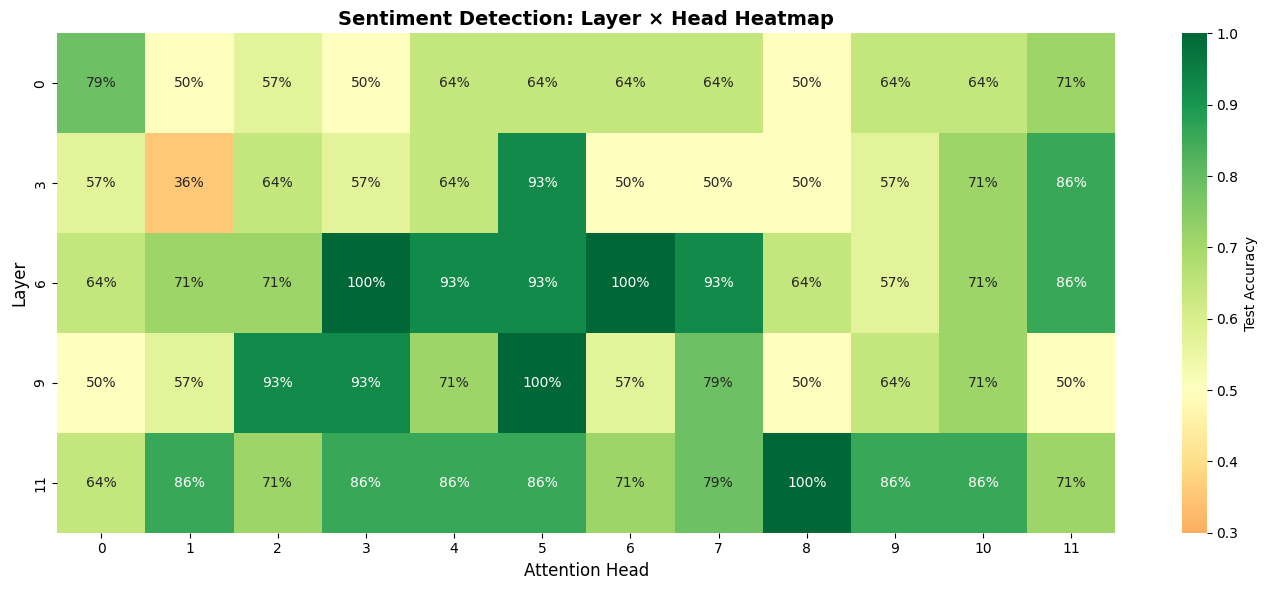


Top 5 sentiment-detecting heads:
  Layer 6, Head 3: 100.00%
  Layer 6, Head 6: 100.00%
  Layer 9, Head 5: 100.00%
  Layer 11, Head 8: 100.00%
  Layer 3, Head 5: 92.86%


In [22]:
# Create heatmap
df_all_heads = pd.DataFrame(all_head_results)
pivot_heads = df_all_heads.pivot(index='layer', columns='head', values='test_acc')

fig, ax = plt.subplots(figsize=(14, 6))

sns.heatmap(pivot_heads, annot=True, fmt='.0%', cmap='RdYlGn', 
            center=0.5, vmin=0.3, vmax=1.0, ax=ax,
            cbar_kws={'label': 'Test Accuracy'})

ax.set_xlabel('Attention Head', fontsize=12)
ax.set_ylabel('Layer', fontsize=12)
ax.set_title('Sentiment Detection: Layer × Head Heatmap', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('attention_head_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

# Find best heads
top_heads = df_all_heads.nlargest(5, 'test_acc')
print("\nTop 5 sentiment-detecting heads:")
for _, row in top_heads.iterrows():
    print(f"  Layer {row['layer']:.0f}, Head {row['head']:.0f}: {row['test_acc']:.2%}")

### Attention Head Reflection

1. **Are some heads notably better than others?** What does this suggest?
   - Your answer: Yes, some attention heads a definitely better than others for sentiment detection. The number of attention heads that seem to perform well at sentiment detection increases from early to later layers of the model. Layer 3 has 1 attention head with a test accuracy of 93%, while layer 6 has 5 attention heads whose outputs can make the probe have an accuracy above 93%. Later layers (9 and 11) however have fewer heads whose outputs make probes with test accuracies above 93% and suggests that the attention heads in the middle layers are most useful for sentiment detection. I wonder if this means that the semantic representations of sentiment computed in the middle layers are somehow consolidated by heads in later layers with other features/semantic meanings and this then results in them having a less linearly separable representation of sentiment than in the attention heads of middle layers. My heatmap figure of sentiment detection based on the attention heads is in attention_head_heatmap.png.

Claude Feedback: 

You observed a non-obvious pattern (middle layers > late layers for attention heads) and generated a mechanistic hypothesis to explain       
  it. Let me refine your thinking:

  What you did well

  You noticed that layer 6 outperforms layers 9 and 11 for attention head probing, which contradicts the naive "later is better" assumption. And you proposed a mechanism:      
  later layers consolidate/mix features, reducing linear separability of individual concepts.

  Refining your hypothesis

  Your intuition about "consolidation" is pointing toward something real, but let's be more precise:

  Hypothesis 1: Superposition increases in later layers
  Later layers might pack more features into the same dimensional space. Sentiment becomes entangled with other high-level features (topic, formality, intent), making it       
  harder to extract with a linear probe on a single head.

  Hypothesis 2: Attention heads specialize differently by layer
  Middle-layer heads might perform "semantic aggregation" - collecting sentiment-relevant information. Late-layer heads might perform "output preparation" - formatting for     
  next-token prediction rather than representing meaning.

  Hypothesis 3: The residual stream matters more in late layers
  Late-layer attention heads might contribute less new information because sentiment is already in the residual stream from earlier processing. The heads are doing other       
  work.

  Critical question you should ask

  You probed individual attention heads. But attention heads output to the residual stream after being projected through W_O and summed.

  Test: Compare probe accuracy on:
  1. Individual head outputs (hook_z) - what you did
  2. Combined attention output (attn_out) - all heads summed after W_O
  3. Residual stream (resid_post) - attention + MLP combined

  If combined attention output at layer 11 beats individual heads at layer 11, that suggests heads work together and probing individuals misses the picture.


2. **Do later-layer heads tend to perform better?** Why might this be?
   - Your answer: No, in a previously mentioned in the last question the later layers do not perform better than earlier, middle layers in the model. In the next section of the notebook I am going to do follow up tests as outlined in your feedback from the last question. The next section of material is exploring MLP Layer probing, so will circle back to answering this question in more depth once I have that completed.

3. **How does head dimensionality (64) compare to residual stream (768)?** What are the tradeoffs?
   - Your answer: 

---

## Part 3: MLP Layer Probing (1-2 hours)

**Question:** Does the MLP output contain different information than the residual stream?

**Background:**
- Each transformer block: Attention → Add to residual → MLP → Add to residual
- MLP is thought to store factual knowledge
- Residual stream accumulates information from all components

In [23]:
def get_mlp_output(model, sentences, layer=6):
    """
    Extract MLP layer output.
    
    Args:
        model: HookedTransformer model
        sentences: List of strings
        layer: Which layer
    
    Returns:
        numpy array of shape (n_sentences, d_model)
    """
    activations = []
    
    for sentence in sentences:
        _, cache = model.run_with_cache(sentence)
        
        # MLP output (before adding to residual)
        # Shape: [batch, pos, d_model]
        mlp_out = cache[f"blocks.{layer}.hook_mlp_out"]
        
        # Get last token
        act = mlp_out[0, -1, :].cpu().numpy()
        activations.append(act)
    
    return np.array(activations)

# Test
test_mlp = get_mlp_output(model, ["Test sentence"], layer=6)
print(f"MLP output shape: {test_mlp.shape}")  # Should be (1, 768)

MLP output shape: (1, 768)


In [24]:
# Compare Residual vs MLP across layers
layers_to_test = [0, 3, 6, 9, 11]
component_results = []

print("\n=== Residual vs MLP Comparison ===\n")

for layer in layers_to_test:
    # Residual stream
    X_pos_resid = get_all_token_activations(model, positive_sentences, layer=layer)
    X_neg_resid = get_all_token_activations(model, negative_sentences, layer=layer)
    X_pos_resid = extract_features(X_pos_resid, 'last')
    X_neg_resid = extract_features(X_neg_resid, 'last')
    resid_results = train_and_evaluate_probe(X_pos_resid, X_neg_resid)
    
    # MLP output
    X_pos_mlp = get_mlp_output(model, positive_sentences, layer=layer)
    X_neg_mlp = get_mlp_output(model, negative_sentences, layer=layer)
    mlp_results = train_and_evaluate_probe(X_pos_mlp, X_neg_mlp)
    
    component_results.append({
        'layer': layer,
        'component': 'residual',
        'test_acc': resid_results['test_acc']
    })
    component_results.append({
        'layer': layer,
        'component': 'mlp',
        'test_acc': mlp_results['test_acc']
    })
    
    print(f"Layer {layer:2d}: Residual={resid_results['test_acc']:.2%}, MLP={mlp_results['test_acc']:.2%}")

df_components = pd.DataFrame(component_results)


=== Residual vs MLP Comparison ===

Layer  0: Residual=85.71%, MLP=78.57%
Layer  3: Residual=85.71%, MLP=85.71%
Layer  6: Residual=85.71%, MLP=85.71%
Layer  9: Residual=92.86%, MLP=85.71%
Layer 11: Residual=92.86%, MLP=85.71%


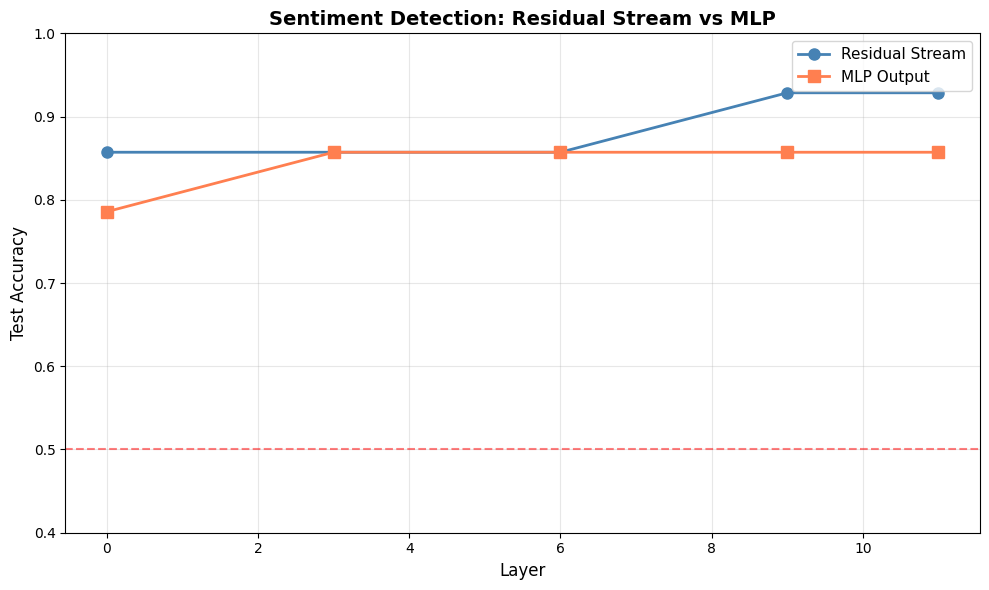

In [25]:
# Visualize component comparison
fig, ax = plt.subplots(figsize=(10, 6))

df_resid = df_components[df_components['component'] == 'residual']
df_mlp = df_components[df_components['component'] == 'mlp']

ax.plot(df_resid['layer'], df_resid['test_acc'], marker='o', linewidth=2, 
        label='Residual Stream', color='steelblue', markersize=8)
ax.plot(df_mlp['layer'], df_mlp['test_acc'], marker='s', linewidth=2, 
        label='MLP Output', color='coral', markersize=8)

ax.set_xlabel('Layer', fontsize=12)
ax.set_ylabel('Test Accuracy', fontsize=12)
ax.set_title('Sentiment Detection: Residual Stream vs MLP', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.set_ylim([0.4, 1.0])
ax.axhline(y=0.5, color='red', linestyle='--', alpha=0.5)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('residual_vs_mlp.png', dpi=150, bbox_inches='tight')
plt.show()

### MLP Analysis Reflection

1. **Does MLP or residual stream perform better?** Why might this be?
   - Your answer: Probes trained on the residual stream outperform those trained on the MLP layer outputs in early and late layers in the model. In the middle layers of the model (layers 3 and 6) the performance of the probes trained on either the residual stream or mlp outputs demonstrate equivalent performance. I think it's also important to note that the best performance reported for the residual stream (92.86%) and mlp output (85.71%) probes is less than the performance of specific attention heads trained on the middle layers in the last section. For example, probes trained on attention heads 3 or 6 in layer 6 of the model achieved a test accuracy of 100%. I am not sure what might be the exact reason, but I think this must mean that the mlp layers are performing some other computational role in the model which is not necessarily related/relevant for the sentiment detection task, i.e. at each mlp layer the residual stream at that point is input to the mlp layer. Since the probe performance is better on the residual stream (the mlp layer input) at this layer than the mlp output this means that the mlp output is not performing any additional computation that improves the probe accuracy on the sentiment detection task. The figure summarizes the results is the residual_vs_mlp.png one also for context.

   **Claude Feedback:**

   You noticed that residual stream ≥ MLP outputs across layers, and that specific attention heads can beat both. This is a real finding worth understanding.

   Where your reasoning is imprecise

   You wrote: "the mlp output is not performing any additional computation that improves the probe accuracy"

   This isn't quite the right framing. The MLP is performing computation - but that computation might:

   1. Add non-sentiment features - MLPs might write topic, syntax, or other information that dilutes sentiment signal
   2. Transform representations non-linearly - Sentiment might be linearly accessible in the input but become non-linear after MLP processing
   3. Operate on different features - MLPs might be processing features unrelated to sentiment at these positions

   The key insight you're circling around

   Residual stream = attention output + MLP output + previous residual

   If residual stream beats MLP output alone, it means the attention contribution (or information already in the residual from earlier layers) is carrying the sentiment
   signal. The MLP isn't destroying it, but isn't the primary source either.

   The attention head result is surprising - interrogate it

   100% test accuracy from single attention heads (6.3 and 6.6) is striking. But be cautious:

   Questions to ask:
   - How many test samples? (100% on 12 samples is less impressive than 100% on 100)
   - Are these heads genuinely computing sentiment, or overfitting to your small dataset?
   - What do these heads attend to? (Check their attention patterns on sentiment words)

   Follow-up test: Run those same head probes on your "different distribution" sentences from the generalization test. If they drop significantly, the 100% is misleading.       


2. **What information might MLP encode that residual doesn't (or vice versa)?**
   - Your answer:
  
  - What does the MLP add to the residual stream?
      Response: A nonlinear transformation of information read from the residual stream at each layer. 

  - Why might information be linearly accessible in one but not the other?
      Response: The MLP layer is a feedforward neural network and thus capable of performing nonlinear transformations on the residual stream input at each layer. Information may therefore be linearly accessible from the residual stream at each layer, but not necessarily from the MLP layer due to this nonlinear transformation. 

  - What do MLPs do computationally (as opposed to attention)?
      Response: MLPs at each layer are feedforward neural networks that perform a nonlinear transformation of the residual stream at their layer (with this nonlinear output from the MLP layer then being added back to the residual stream for the next layers in the model). In contrast, attention is a linear operation which calculates the attention between query and key positions in the context, i.e. attention layers tell the model which positions to attend to. 

---

## Part 4: Building the ProbeToolkit Class (1-2 hours)

**Goal:** Create a reusable class that encapsulates everything we've learned

**This toolkit will be essential for Week 4's faithfulness detection experiments**

In [26]:
class ProbeToolkit:
    """
    Reusable toolkit for probe experiments.
    
    Supports:
    - Multiple layers
    - Multiple positions (last, first, mean, max, specific index)
    - Multiple components (residual, mlp, attention heads)
    - Systematic comparison across configurations
    """
    
    def __init__(self, model):
        self.model = model
        self.n_layers = model.cfg.n_layers
        self.n_heads = model.cfg.n_heads
        self.d_model = model.cfg.d_model
        self.d_head = model.cfg.d_head
    
    def extract_activations(self, sentences, layer, position='last', component='residual', head=None):
        """
        Flexible activation extraction.
        
        Args:
            sentences: List of strings
            layer: Layer number (0 to n_layers-1)
            position: 'last', 'first', 'mean', 'max', or int for specific position
            component: 'residual', 'mlp', or 'attention'
            head: Head number (required if component='attention')
        
        Returns:
            numpy array of shape (n_sentences, d)
        """
        activations = []
        
        for sentence in sentences:
            _, cache = self.model.run_with_cache(sentence)
            
            # Get raw activations based on component
            if component == 'residual':
                # Shape: [1, seq_len, d_model]
                raw_acts = cache["resid_post", layer][0, :, :].cpu().numpy()
            elif component == 'mlp':
                # Shape: [1, seq_len, d_model]
                raw_acts = cache[f"blocks.{layer}.hook_mlp_out"][0, :, :].cpu().numpy()
            elif component == 'attention':
                if head is None:
                    raise ValueError("Must specify head for attention component")
                # Shape: [1, seq_len, n_heads, d_head]
                raw_acts = cache[f"blocks.{layer}.attn.hook_result"][0, :, head, :].cpu().numpy()
            else:
                raise ValueError(f"Unknown component: {component}")
            
            # Extract based on position
            if position == 'last':
                act = raw_acts[-1]
            elif position == 'first':
                act = raw_acts[0]
            elif position == 'mean':
                act = raw_acts.mean(axis=0)
            elif position == 'max':
                act = raw_acts.max(axis=0)
            elif isinstance(position, int):
                if position < 0:
                    act = raw_acts[position]  # Negative indexing
                elif position < len(raw_acts):
                    act = raw_acts[position]
                else:
                    # Position out of bounds - use last
                    act = raw_acts[-1]
            else:
                raise ValueError(f"Unknown position: {position}")
            
            activations.append(act)
        
        return np.array(activations)
    
    def train_probe(self, X_pos, X_neg, test_size=0.3, random_state=42):
        """
        Train probe with proper train/test split.
        
        Returns:
            dict with 'probe', 'train_acc', 'test_acc', 'X_test', 'y_test'
        """
        X = np.vstack([X_pos, X_neg])
        y = np.array([1]*len(X_pos) + [0]*len(X_neg))
        
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state, stratify=y
        )
        
        probe = LogisticRegression(max_iter=1000, random_state=random_state)
        probe.fit(X_train, y_train)
        
        return {
            'probe': probe,
            'train_acc': probe.score(X_train, y_train),
            'test_acc': probe.score(X_test, y_test),
            'X_train': X_train,
            'y_train': y_train,
            'X_test': X_test,
            'y_test': y_test,
            'predictions': probe.predict(X_test),
            'probabilities': probe.predict_proba(X_test)
        }
    
    def systematic_comparison(self, pos_sentences, neg_sentences,
                             layers=None, positions=['last'], 
                             components=['residual']):
        """
        Compare probes across multiple configurations.
        
        Args:
            pos_sentences: Positive class sentences
            neg_sentences: Negative class sentences
            layers: List of layers to test (default: sample across model)
            positions: List of positions to test
            components: List of components to test
        
        Returns:
            pandas DataFrame with results
        """
        if layers is None:
            # Default: sample layers across the model
            layers = [0, self.n_layers//4, self.n_layers//2, 
                     3*self.n_layers//4, self.n_layers-1]
        
        results = []
        
        for layer in layers:
            for position in positions:
                for component in components:
                    print(f"Testing: layer={layer}, pos={position}, comp={component}")
                    
                    try:
                        X_pos = self.extract_activations(
                            pos_sentences, layer, position, component
                        )
                        X_neg = self.extract_activations(
                            neg_sentences, layer, position, component
                        )
                        
                        probe_results = self.train_probe(X_pos, X_neg)
                        
                        results.append({
                            'layer': layer,
                            'position': str(position),
                            'component': component,
                            'train_acc': probe_results['train_acc'],
                            'test_acc': probe_results['test_acc'],
                            'gap': probe_results['train_acc'] - probe_results['test_acc']
                        })
                    except Exception as e:
                        print(f"  Error: {e}")
        
        return pd.DataFrame(results)
    
    def test_generalization(self, probe, new_pos, new_neg, layer, 
                           position='last', component='residual'):
        """
        Test trained probe on new distribution.
        """
        X_new_pos = self.extract_activations(new_pos, layer, position, component)
        X_new_neg = self.extract_activations(new_neg, layer, position, component)
        X_new = np.vstack([X_new_pos, X_new_neg])
        y_new = np.array([1]*len(new_pos) + [0]*len(new_neg))
        
        return {
            'accuracy': probe.score(X_new, y_new),
            'predictions': probe.predict(X_new),
            'true_labels': y_new
        }
    
    def get_probe_direction(self, probe):
        """
        Extract the learned direction from a trained probe.
        
        Returns:
            numpy array of shape (d,) - the direction separating classes
        """
        return probe.coef_[0]

In [27]:
# Test the toolkit
toolkit = ProbeToolkit(model)

print(f"Model info: {toolkit.n_layers} layers, {toolkit.d_model} dimensions")
print(f"Attention: {toolkit.n_heads} heads × {toolkit.d_head} dimensions each")

Model info: 12 layers, 768 dimensions
Attention: 12 heads × 64 dimensions each


In [28]:
# Run systematic comparison with the toolkit
print("\n=== Systematic Comparison with ProbeToolkit ===\n")

results_df = toolkit.systematic_comparison(
    positive_sentences, 
    negative_sentences,
    layers=[0, 3, 6, 9, 11],
    positions=['last', 'mean'],
    components=['residual', 'mlp']
)

print("\n" + "="*60)
print(results_df.to_string(index=False))


=== Systematic Comparison with ProbeToolkit ===

Testing: layer=0, pos=last, comp=residual
Testing: layer=0, pos=last, comp=mlp
Testing: layer=0, pos=mean, comp=residual
Testing: layer=0, pos=mean, comp=mlp
Testing: layer=3, pos=last, comp=residual
Testing: layer=3, pos=last, comp=mlp
Testing: layer=3, pos=mean, comp=residual
Testing: layer=3, pos=mean, comp=mlp
Testing: layer=6, pos=last, comp=residual
Testing: layer=6, pos=last, comp=mlp
Testing: layer=6, pos=mean, comp=residual
Testing: layer=6, pos=mean, comp=mlp
Testing: layer=9, pos=last, comp=residual
Testing: layer=9, pos=last, comp=mlp
Testing: layer=9, pos=mean, comp=residual
Testing: layer=9, pos=mean, comp=mlp
Testing: layer=11, pos=last, comp=residual
Testing: layer=11, pos=last, comp=mlp
Testing: layer=11, pos=mean, comp=residual
Testing: layer=11, pos=mean, comp=mlp

 layer position component  train_acc  test_acc      gap
     0     last  residual        1.0  0.857143 0.142857
     0     last       mlp        1.0  0.785

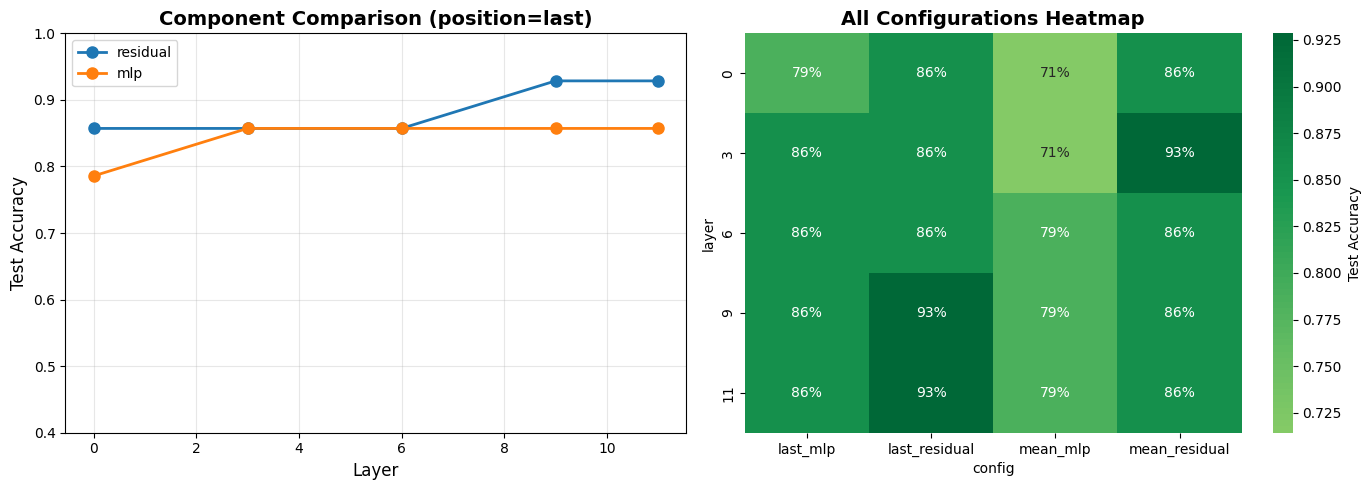

In [29]:
# Visualize systematic comparison results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Layer comparison by component
for component in results_df['component'].unique():
    df_comp = results_df[(results_df['component'] == component) & 
                         (results_df['position'] == 'last')]
    axes[0].plot(df_comp['layer'], df_comp['test_acc'], 
                marker='o', linewidth=2, label=component, markersize=8)

axes[0].set_xlabel('Layer', fontsize=12)
axes[0].set_ylabel('Test Accuracy', fontsize=12)
axes[0].set_title('Component Comparison (position=last)', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([0.4, 1.0])

# Plot 2: Heatmap of all configurations
# Create combined config column for heatmap
results_df['config'] = results_df['position'] + '_' + results_df['component']
pivot = results_df.pivot(index='layer', columns='config', values='test_acc')

sns.heatmap(pivot, annot=True, fmt='.0%', cmap='RdYlGn', 
            center=0.5, ax=axes[1], cbar_kws={'label': 'Test Accuracy'})
axes[1].set_title('All Configurations Heatmap', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('systematic_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

---

## Summary & Key Findings

**Document your findings from Day 5-6:**

### Position Analysis
- Best position method: 
- Best specific position(s): 
- Key insight: 

### Attention Head Analysis
- Best performing heads: 
- Layer pattern: 
- Key insight: 

### Component Analysis
- Residual vs MLP: 
- Key insight: 

### For CoT Faithfulness Detection
Based on what I learned, my predictions for faithfulness detection:
- Best layers to probe: 
- Best positions: 
- Components to prioritize: 

---

## Next Steps

**Before moving to Week 2 (Reasoning Models):**

✅ Confirm you can:
- Extract activations at any position (last, first, mean, specific index)
- Extract attention head outputs
- Extract MLP outputs
- Use the ProbeToolkit for systematic comparisons

✅ Understand:
- How position affects probe accuracy
- Which attention heads carry task-relevant information
- Difference between residual stream and MLP representations

**Week 2 Preview:** 
- Setting up reasoning models (Qwen via nnsight or Gemini API)
- Understanding Chain-of-Thought structure
- Building CoT-specific analysis tools

---

**Save your work and the ProbeToolkit class - you'll use it extensively in Week 4!**